In [9]:
%pip install openpyxl

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl


In [11]:
%%writefile get_data.sh
if [ ! -f HousePricePrediction.xlsx ]; then
  wget -O HousePricePrediction.xlsx https://www.dropbox.com/scl/fi/ewhij69682gada6a1ms1s/HousePricePrediction.xlsx?rlkey=bpxyfeqxxkmo3gmbg8xx79nmn&dl=0
fi

Overwriting get_data.sh


In [12]:
!bash get_data.sh

In [13]:
dataset = pd.read_excel("HousePricePrediction.xlsx")

# Printing first 5 records of the dataset
print(dataset.head(5))

   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


In [14]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 4
Integer variables: 6
Float variables: 3


<ipython-input-15-8feaf9d49085>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(),


<Axes: >

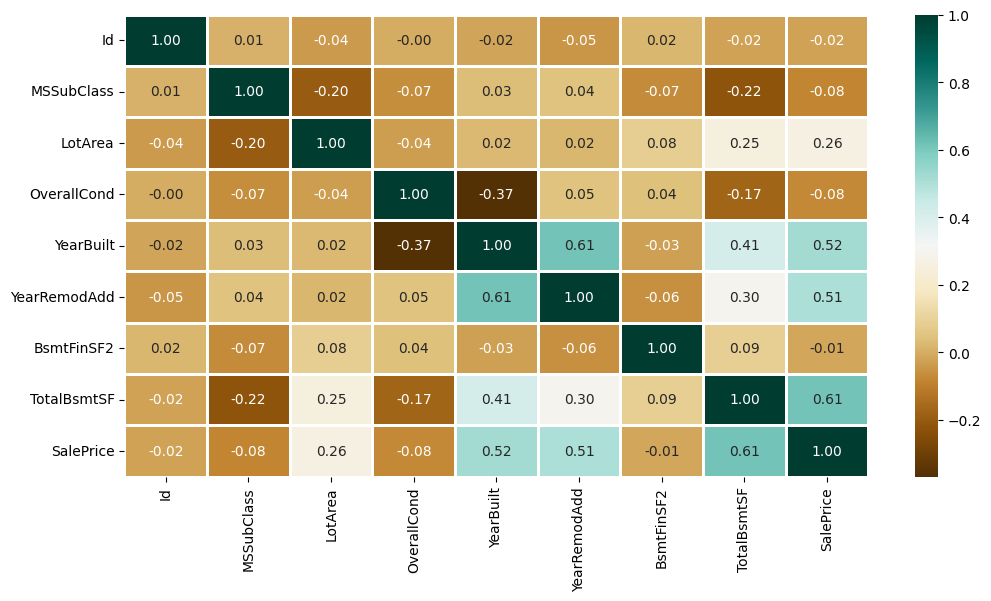

In [15]:
plt.figure(figsize=(12, 6))
sns.heatmap(dataset.corr(),
			cmap = 'BrBG',
			fmt = '.2f',
			linewidths = 2,
			annot = True)


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

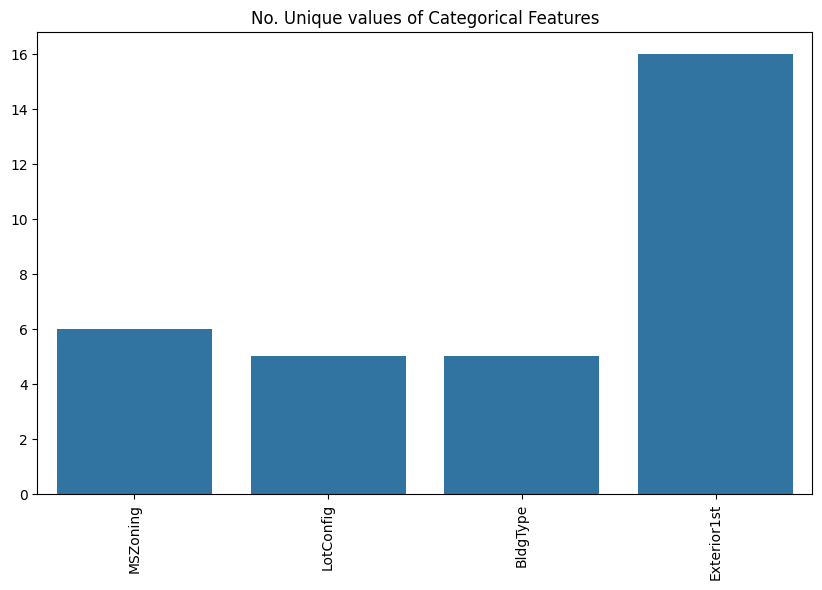

In [16]:
unique_values = []
for col in object_cols:
    unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

<ipython-input-17-648a2c778247>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


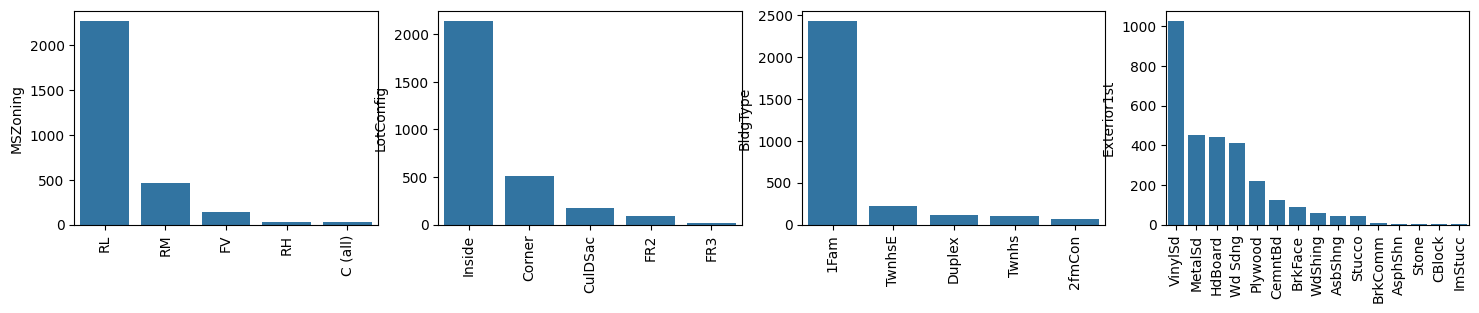

In [17]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
	y = dataset[col].value_counts()
	plt.subplot(11, 4, index)
	plt.xticks(rotation=90)
	sns.barplot(x=list(y.index), y=y)
	index += 1


In [18]:
dataset.drop(['Id'],
			axis=1,
			inplace=True)

In [19]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(
dataset['SalePrice'].mean())


In [20]:
dataset.isnull().sum()

MSSubClass      0
MSZoning        4
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     1
BsmtFinSF2      1
TotalBsmtSF     1
SalePrice       0
dtype: int64

In [21]:
new_dataset = dataset.dropna()


In [22]:
new_dataset.isnull().sum()


MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

In [23]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
	len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [24]:
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
	X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [26]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1870512931870423


In [27]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)


0.19253593516474685

In [28]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.18741683841599854
